In [15]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import os
from torch.utils.data import DataLoader
from tqdm import tqdm

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
path = '/kaggle/working/data'
if not os.path.exists(path):
    os.mkdir(path)

transfor = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root=path, train=True, download=True, transform=transfor)
testset = datasets.CIFAR10(root=path, train=False, download=True, transform=transfor)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=False, num_workers=2)
# 이미지 평균 및 표준편차 계산
mean = torch.zeros(3)
std = torch.zeros(3)
nb_samples = 0.0
for images, _ in trainloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples
    
mean /= nb_samples
std /= nb_samples

mean = mean.numpy().tolist()
std = std.numpy().tolist()

print(mean)
print(std)

Files already downloaded and verified
Files already downloaded and verified
[0.4913995563983917, 0.48215848207473755, 0.44653093814849854]
[0.20230084657669067, 0.19941289722919464, 0.20096157491207123]


In [18]:
# 데이터셋 전처리
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.875, 1.0)),  # Random crop 224x224
    transforms.RandomHorizontalFlip(),  # 수평으로 뒤집기
    transforms.Resize((224, 224)),  # 크기 변경
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # 색상 변형
    transforms.ToTensor(),
    transforms.Normalize(mean, std),  # 계산된 평균과 표준편차를 이용한 정규화
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 변경
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),  # 계산된 평균과 표준편차를 이용한 정규화
])


# CIFAR-10
trainset = datasets.CIFAR10(root=path, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root=path, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
# 데이터로더 정보를 출력하는 함수
def print_dataloader_info(dataloader, loader_name):
    print(f"\n{loader_name} 정보:")
    for batch_idx, (images, labels) in enumerate(dataloader):
        print(f"배치 인덱스: {batch_idx}")
        print(f"이미지 크기: {images.size()}")
        if isinstance(labels, torch.Tensor):
            print(f"라벨 크기: {labels.size()}")
            print(f'라벨의 데이터타입 : {labels[0].dtype}')
        else:
            print(f"라벨 크기: {len(labels)}")
            print(f'라벨의 데이터타입 : {type(labels[0])}')
        if batch_idx == 0:  # 첫 번째 배치 정보만 출력
            break

# train_loader 정보 출력
print_dataloader_info(trainloader, "Train Loader")

# test_loader 정보 출력
print_dataloader_info(testloader, "Test Loader")


Train Loader 정보:
배치 인덱스: 0
이미지 크기: torch.Size([64, 3, 224, 224])
라벨 크기: torch.Size([64])
라벨의 데이터타입 : torch.int64

Test Loader 정보:
배치 인덱스: 0
이미지 크기: torch.Size([64, 3, 224, 224])
라벨 크기: torch.Size([64])
라벨의 데이터타입 : torch.int64


In [20]:
class BasicBlock(nn.Module):
    expansion_factor = 1
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU())

        self.conv2 = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU())

        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*self.expansion_factor))

        self.relu1 = nn.ReLU()

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)

        x += self.residual(identity) # shortcut connection
        x = self.relu1(x)
        return x

In [21]:
class BottleNeck(nn.Module):
    expansion_factor=4
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU())

        self.conv2 = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU())

        self.conv3 = nn.Sequential(nn.Conv2d(out_channels, out_channels * self.expansion_factor, kernel_size=1, stride=1, bias=False),
                                   nn.BatchNorm2d(out_channels * self.expansion_factor))

        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion_factor:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion_factor, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion_factor))

        self.relu1 = nn.ReLU()

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x += self.residual(identity) # shortcut connection
        x = self.relu1(x)
        return x

In [22]:
class Resnet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(Resnet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        self.conv2 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.conv3 = self._make_layer(block,128, num_blocks[1], stride=2)
        self.conv4 = self._make_layer(block,256, num_blocks[2], stride=2)
        self.conv5 = self._make_layer(block,512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512 * block.expansion_factor, num_classes)

        self._init_layer()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks -1) # [stride, 1, 1, ..., 1] 1은 num_block -1 개
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion_factor
        return nn.Sequential(*layers)

    def _init_layer(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [23]:
class Model:
    def resnet18(self):
        return Resnet(BasicBlock, [2, 2, 2, 2])

    def resnet34(self):
        return Resnet(BasicBlock, [3, 4, 6, 3])

    def resnet50(self):
        return Resnet(BottleNeck, [3, 4, 6, 3])

    def resnet101(self):
        return Resnet(BottleNeck, [3, 4, 23, 3])

    def resnet152(self):
        return Resnet(BottleNeck, [3, 8, 36, 3])

In [24]:
# Model 클래스
class Model:
    def resnet101(self):
        return models.resnet101(pretrained=False, num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model().resnet101()
model = model.to(device)

input_tensor = torch.randn(1, 3, 224, 224).to(device)

y = model(input_tensor)
print(y.size())  # torch.Size([1, 10])


torch.Size([1, 10])


In [25]:
!pip install torchsummary
from torchsummary import summary

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화 및 디바이스로 이동
model = Model().resnet101()
model = model.to(device)

# 모델 요약 출력
summary(model, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [26]:
# CUDA 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
initial_learning_rate = 0.1
num_epochs = 50
epoch_step = 5

# Loss function, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=initial_learning_rate, momentum=0.9, weight_decay=0.0001)

# scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)

In [27]:
# 모델을 CUDA로 이동
model.to(device)

def model_train(model, data_loader, criterion, optimizer, epoch):
    model.train()

    global epoch_step
    running_size, running_loss, correct = 0.0, 0.0, 0.0

    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        pbar = tqdm(data_loader)
    else:
        pbar = data_loader

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_size += images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            pbar.set_description('[Training] loss: ' +
                                f'{running_loss / running_size:.4f}, accuracy: ' +
                                f'{correct / running_size:.4f}')
        del images, labels, outputs, loss
        torch.cuda.empty_cache()
        
    avg_accuracy = correct / running_size
    avg_loss = running_loss / running_size

    return avg_loss, avg_accuracy

def model_eval(model, data_loader, criterion, epoch):
    model.eval()
    with torch.no_grad():
        running_loss, correct = 0.0, 0.0

        if (epoch + 1) % epoch_step == 0 or epoch == 0:
            pbar = tqdm(data_loader)
        else:
            pbar = data_loader

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pred = outputs.argmax(dim=1)

            correct += torch.sum(pred == labels).item()
            running_loss += criterion(outputs, labels).item() * images.size(0)

        accuracy = correct / len(data_loader.dataset)
        loss = running_loss / len(data_loader.dataset)
        return loss, accuracy

In [28]:
# 모델 학습 및 평가 코드
loss, accuracy = [], []
num_epochs = 50
epoch_step = 5

for epoch in range(num_epochs):
    train_loss, train_accuracy = model_train(model, trainloader, criterion, optimizer, epoch)
    test_loss, test_accuracy = model_eval(model, testloader, criterion, epoch)

    loss.append([train_loss, test_loss])
    accuracy.append([train_accuracy, test_accuracy])

    scheduler.step(test_loss)  # 스케줄러 업데이트

    if (epoch + 1) % epoch_step == 0 or epoch == 0:
        print(f"epoch {epoch+1:03d}, Training loss: " + 
              f"{train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

# 모델 상태 저장
model_save_path = '/kaggle/working/data/model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

100%|██████████| 157/157 [00:27<00:00,  5.78it/s]

epoch 001, Training loss: 2.5621, Training accuracy: 0.1025
Test loss: 2.3088, Test accuracy: 0.0999



100%|██████████| 157/157 [00:27<00:00,  5.77it/s]

epoch 005, Training loss: 2.1157, Training accuracy: 0.1919
Test loss: 2.2013, Test accuracy: 0.1653



100%|██████████| 157/157 [00:27<00:00,  5.75it/s]

epoch 010, Training loss: 1.1649, Training accuracy: 0.5863
Test loss: 1.0895, Test accuracy: 0.6163



100%|██████████| 157/157 [00:27<00:00,  5.74it/s]

epoch 015, Training loss: 0.6558, Training accuracy: 0.7725
Test loss: 0.6743, Test accuracy: 0.7764



100%|██████████| 157/157 [00:27<00:00,  5.74it/s]

epoch 020, Training loss: 0.5116, Training accuracy: 0.8232
Test loss: 0.5172, Test accuracy: 0.8243



100%|██████████| 157/157 [00:27<00:00,  5.74it/s]

epoch 025, Training loss: 0.4332, Training accuracy: 0.8494
Test loss: 0.4895, Test accuracy: 0.8342



100%|██████████| 157/157 [00:27<00:00,  5.76it/s]

epoch 030, Training loss: 0.3809, Training accuracy: 0.8670
Test loss: 0.5271, Test accuracy: 0.8292



100%|██████████| 157/157 [00:27<00:00,  5.77it/s]

epoch 035, Training loss: 0.3488, Training accuracy: 0.8792
Test loss: 0.5333, Test accuracy: 0.8242



100%|██████████| 157/157 [00:27<00:00,  5.75it/s]

epoch 040, Training loss: 0.3237, Training accuracy: 0.8880
Test loss: 0.4719, Test accuracy: 0.8491



100%|██████████| 157/157 [00:27<00:00,  5.76it/s]

epoch 045, Training loss: 0.3008, Training accuracy: 0.8962
Test loss: 0.3853, Test accuracy: 0.8724



100%|██████████| 157/157 [00:27<00:00,  5.76it/s]


epoch 050, Training loss: 0.2854, Training accuracy: 0.9020
Test loss: 0.4941, Test accuracy: 0.8374
Model saved to /kaggle/working/data/model.pth


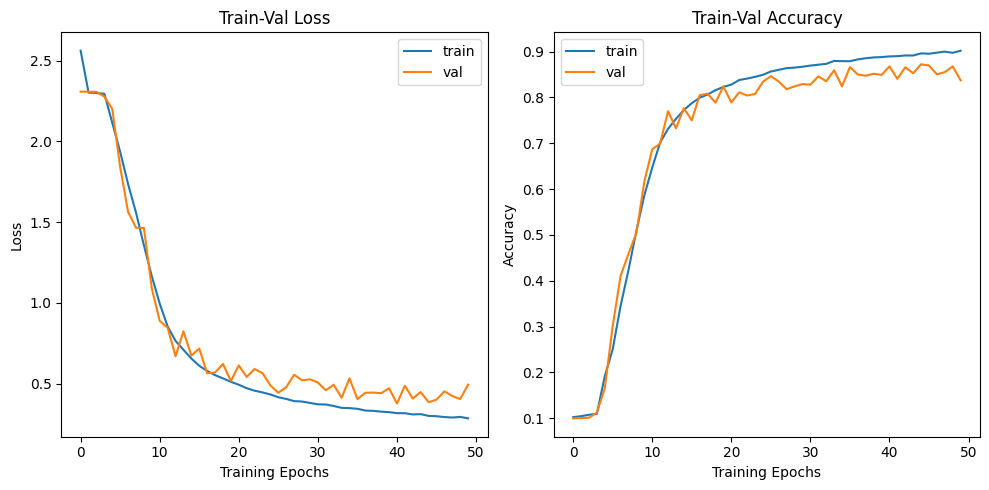

In [31]:
import matplotlib.pyplot as plt

# 손실 그래프
train_losses, val_losses = zip(*loss)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train-Val Loss')

# 정확도 그래프
train_accuracies, val_accuracies = zip(*accuracy)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train-Val Accuracy')

plt.tight_layout()
plt.show()